# Fast GP implementations

In [1]:
%matplotlib inline

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
from matplotlib import rcParams
rcParams["figure.dpi"] = 100
rcParams["figure.figsize"] = 12, 4

## Benchmarking GP codes
Implemented the right way, GPs can be super fast! Let's compare the time it takes to evaluate our GP likelihood and the time it takes to evaluate the likelihood computed with the snazzy ``george`` and ``celerite`` packages. We'll learn how to use both along the way. Let's create a large, fake dataset for these tests:

In [4]:
import numpy as np

np.random.seed(0)
t = np.linspace(0, 10, 10000)
y = np.random.randn(10000)
sigma = np.ones(10000)

### Our GP

In [5]:
def ExpSquaredCovariance(t, A=1.0, l=1.0, tprime=None):
    """
    Return the ``N x M`` exponential squared
    covariance matrix.
    
    """
    if tprime is None:
        tprime = t
    TPrime, T = np.meshgrid(tprime, t)
    return A ** 2 * np.exp(-0.5 * (T - TPrime) ** 2 / l ** 2)


def ln_gp_likelihood(t, y, sigma=0, A=1.0, l=1.0):
    """
    Return the log of the GP likelihood for a datatset y(t)
    with uncertainties sigma, modeled with a Squared Exponential
    Kernel with amplitude A and lengthscale l.
    
    """
    # The covariance and its determinant
    npts = len(t)
    K = ExpSquaredCovariance(t, A=A, l=l) + sigma ** 2 * np.eye(npts)
    
    # The log marginal likelihood
    log_like = -0.5 * np.dot(y.T, np.linalg.solve(K, y))
    log_like -= 0.5 * np.linalg.slogdet(K)[1]
    log_like -= 0.5 * npts * np.log(2 * np.pi)
    
    return log_like

Time to evaluate the GP likelihood:

In [6]:
%%time
ln_gp_likelihood(t, y, sigma)

CPU times: user 33.1 s, sys: 1.84 s, total: 35 s
Wall time: 8.17 s


-14095.321368970013

### george

Let's time how long it takes to do the same operation using the ``george`` package (``pip install george``).

The kernel we'll use is

```python
kernel = amp ** 2 * george.kernels.ExpSquaredKernel(tau ** 2)
```

where ``amp = 1`` and ``tau = 1`` in this case.

To instantiate a GP using ``george``, simply run

```python
gp = george.GP(kernel)
```

The ``george`` package pre-computes a lot of matrices that are re-used in different operations, so before anything else, we'll ask it to compute the GP model for our timeseries:

```python
gp.compute(t, sigma)
```

Note that we've only given it the time array and the uncertainties, so as long as those remain the same, you don't have to re-compute anything. This will save you a lot of time in the long run!

Finally, the log likelihood is given by ``gp.log_likelihood(y)``.

How do the speeds compare? Did you get the same value of the likelihood?

In [7]:
import george

In [8]:
%%time
kernel = george.kernels.ExpSquaredKernel(1.0)
gp = george.GP(kernel)
gp.compute(t, sigma)

CPU times: user 9.41 s, sys: 400 ms, total: 9.81 s
Wall time: 3.42 s


In [9]:
%%time
print(gp.log_likelihood(y))

-14095.32136897017
CPU times: user 681 ms, sys: 9.4 ms, total: 691 ms
Wall time: 115 ms


``george`` also offers a fancy GP solver called the HODLR solver, which makes some approximations that dramatically speed up the matrix algebra. Let's instantiate the GP object again by passing the keyword ``solver=george.HODLRSolver`` and re-compute the log likelihood. How long did that take? Did we get the same value for the log likelihood?

In [10]:
%%time
gp = george.GP(kernel, solver=george.HODLRSolver)
gp.compute(t, sigma)

CPU times: user 564 ms, sys: 68.8 ms, total: 633 ms
Wall time: 106 ms


In [11]:
%%time
gp.log_likelihood(y)

CPU times: user 21.8 ms, sys: 1.73 ms, total: 23.6 ms
Wall time: 3.81 ms


-14116.16895539657

### celerite

The ``george`` package is super useful for GP modeling, and I recommend you read over the [docs and examples](https://george.readthedocs.io/en/latest/). It implements several different [kernels](https://george.readthedocs.io/en/latest/user/kernels/) that come in handy in different situations, and it has support for multi-dimensional GPs. But if all you care about are GPs in one dimension (in this case, we're only doing GPs in the time domain, so we're good), then ``celerite`` is what it's all about:

```bash
pip install celerite
```

Check out the [docs](https://celerite.readthedocs.io/en/stable/) here, as well as several tutorials. There is also a [paper](https://arxiv.org/abs/1703.09710) that discusses the math behind ``celerite``. The basic idea is that for certain families of kernels, there exist **extremely efficient** methods of factorizing the covariance matrices. Whereas GP fitting typically scales with the number of datapoints $N$ as $N^3$, ``celerite`` is able to do everything in order $N$ (!!!) This is a **huge** advantage, especially for datasets with tens or hundreds of thousands of data points. Using ``george`` or any homebuilt GP model for datasets larger than about ``10,000`` points is simply intractable, but with ``celerite`` you can do it in a breeze.

Next we repeat the timing tests, but this time using ``celerite``. Note that the Exponential Squared Kernel is not available in ``celerite``, because it doesn't have the special form needed to make its factorization fast. Instead, we'll use the ``Matern 3/2`` kernel, which is qualitatively similar and can be approximated quite well in terms of the ``celerite`` basis functions:

```python
kernel = celerite.terms.Matern32Term(np.log(1), np.log(1))
```

Note that ``celerite`` accepts the **log** of the amplitude and the **log** of the timescale. Other than this, we can compute the likelihood using the same syntax as ``george``.

How much faster did it run? Is the value of the likelihood different from what you found above? Why?

In [12]:
import celerite
from celerite import terms

In [13]:
%%time
kernel = terms.Matern32Term(np.log(1), np.log(1))
gp = celerite.GP(kernel)
gp.compute(t, sigma)

CPU times: user 1.51 ms, sys: 1.1 ms, total: 2.62 ms
Wall time: 1.9 ms


In [14]:
%%time
gp.log_likelihood(y)

CPU times: user 472 µs, sys: 269 µs, total: 741 µs
Wall time: 473 µs


-14117.50219117748

<div style="background-color: #D6EAF8; border-left: 15px solid #2E86C1;">
    <h1 style="line-height:2.5em; margin-left:1em;">Exercise (the one and only)</h1>
</div>

Let's use what we've learned about GPs in a real application: fitting an exoplanet transit model in the presence of correlated noise.

Below is a (fictitious) light curve for a star with a transiting planet. There is a transit visible to the eye at $t = 0$, which (say) is when you'd expect the planet to transit if its orbit were perfectly periodic. However, a recent paper claims that the planet shows transit timing variations, which are indicative of a second, perturbing planet in the system, and that a transit at $t = 0$ can be ruled out at 3 $\sigma$. **Your task is to verify this claim.**

Assume you have no prior information on the planet other than the transit occurs in the observation window, the depth of the transit is somewhere in the range $(0, 1)$, and the transit duration is somewhere between $0.1$ and $1$ day. You don't know the exact process generating the noise, but you are certain that there's correlated noise in the dataset, so you'll have to pick a reasonable kernel and estimate its hyperparameters.


Fit the transit with a simple inverted Gaussian with three free parameters:

```python
def transit_shape(depth, t0, dur):
    return -depth * np.exp(-0.5 * (t - t0) ** 2 / (0.2 * dur) ** 2)
```

*HINT: I borrowed heavily from [this tutorial](https://celerite.readthedocs.io/en/stable/tutorials/modeling/) in the celerite documentation, so you might want to take a look at it...*

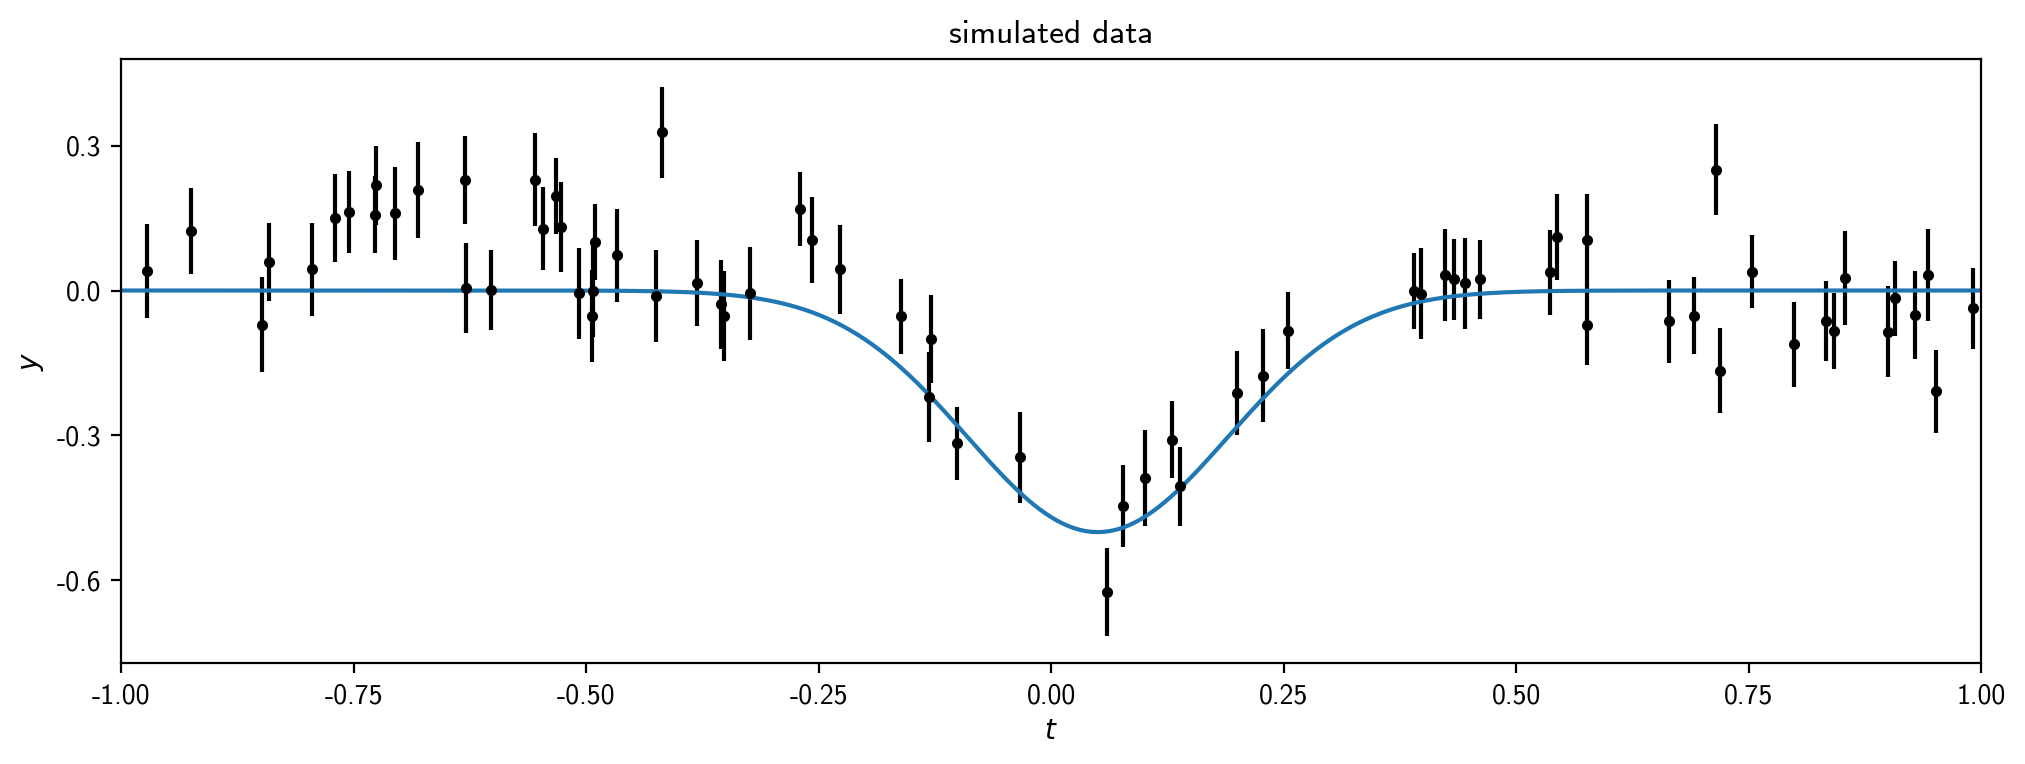

In [15]:
import matplotlib.pyplot as plt
from celerite.modeling import Model
import os

# Define the model
class MeanModel(Model):
    parameter_names = ("depth", "t0", "dur")
    def get_value(self, t):
        return -self.depth * np.exp(-0.5 * (t - self.t0) ** 2 / (0.2 * self.dur) ** 2)

mean_model = MeanModel(depth=0.5, t0=0.05, dur=0.7)
mean_model.parameter_bounds = [(0, 1.0), (-0.1, 0.4), (0.1, 1.0)]
true_params = mean_model.get_parameter_vector()

# Simuate the data
np.random.seed(71)
x = np.sort(np.random.uniform(-1, 1, 70))
yerr = np.random.uniform(0.075, 0.1, len(x))
K = 0.2 * np.exp(-0.5 * (x[:, None] - x[None, :]) ** 2 / 10.5)
K[np.diag_indices(len(x))] += yerr ** 2
y = np.random.multivariate_normal(mean_model.get_value(x), K)
y -= np.nanmedian(y)

# Plot the data
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
t = np.linspace(-1, 1, 1000)
plt.plot(t, mean_model.get_value(t))
plt.ylabel(r"$y$")
plt.xlabel(r"$t$")
plt.xlim(-1, 1)
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))
plt.title("simulated data");

# Save it
X = np.hstack((x.reshape(-1, 1), y.reshape(-1, 1), yerr.reshape(-1, 1)))
if not (os.path.exists("data")):
    os.mkdir("data")
np.savetxt("data/sample_transit.txt", X)

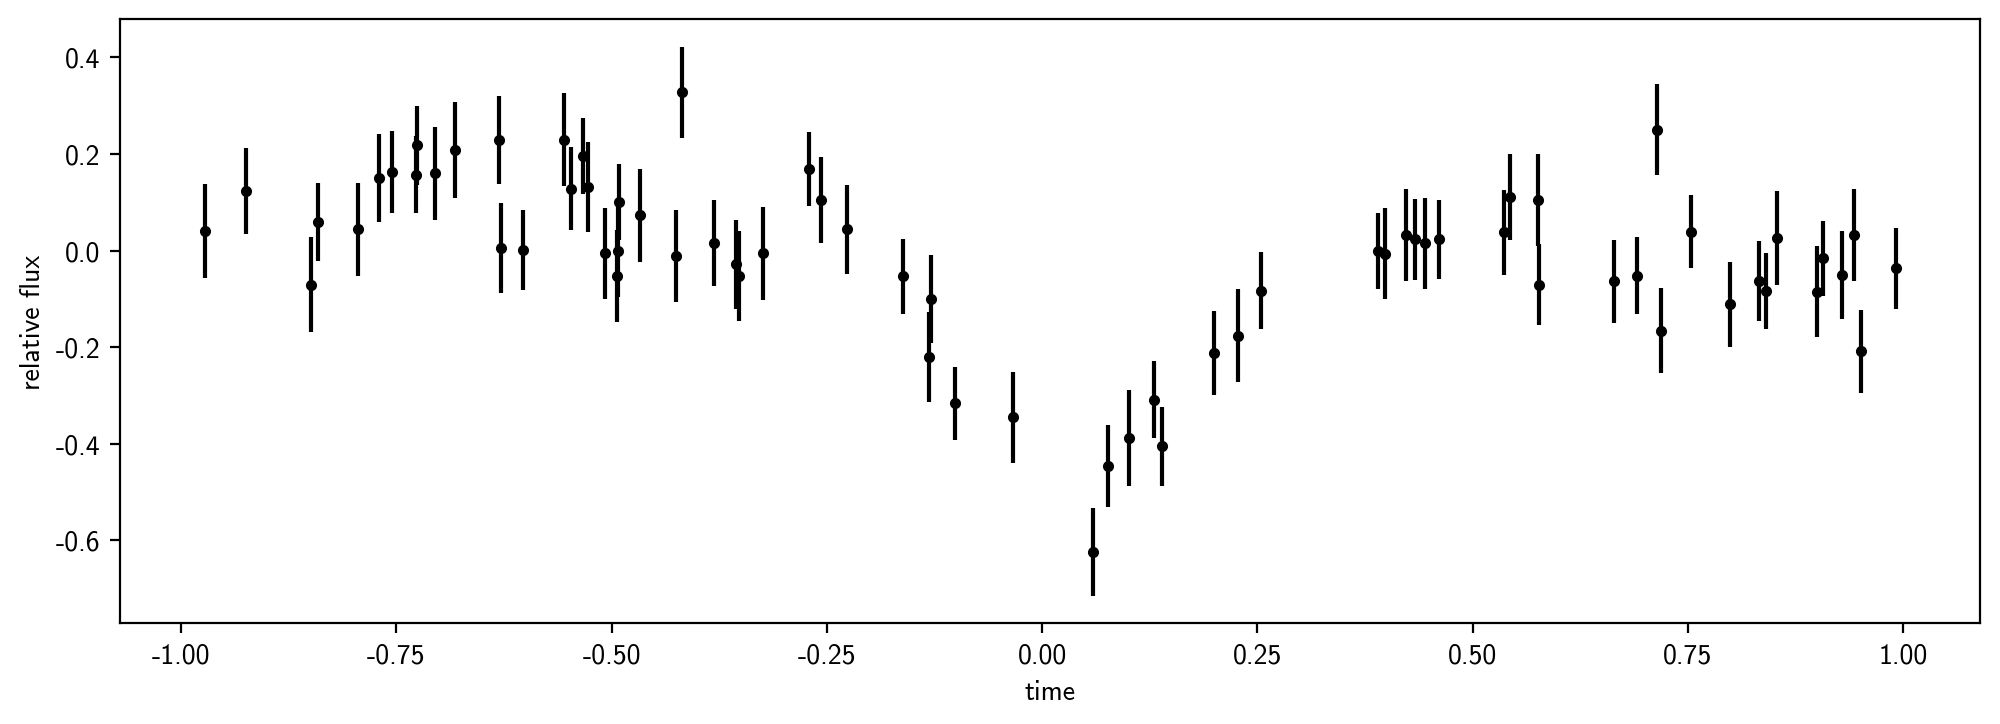

In [16]:
import matplotlib.pyplot as plt
t, y, yerr = np.loadtxt("data/sample_transit.txt", unpack=True)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("time")
plt.ylabel("relative flux");

Initial log-likelihood: 61.43379965918288
Final log-likelihood: 66.67727396616107


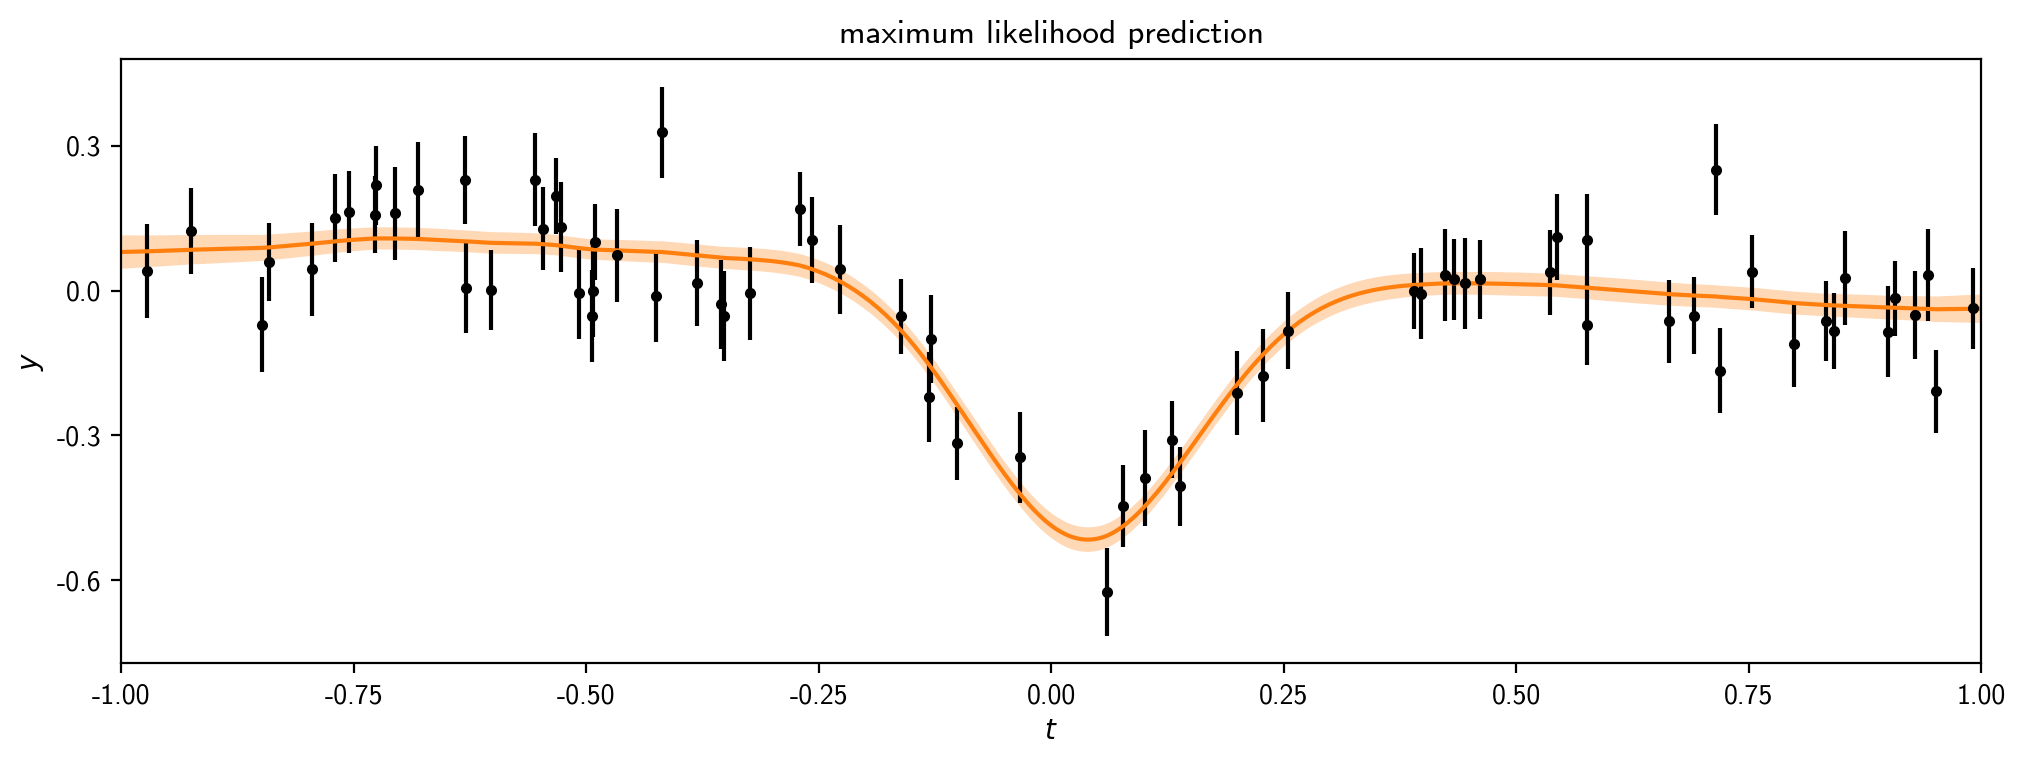

In [17]:
from celerite.modeling import Model
from scipy.optimize import minimize


# Define the transit model as a celerite `Model`
class MeanModel(Model):
    parameter_names = ("depth", "t0", "dur")
    def get_value(self, t):
        return -self.depth * np.exp(-0.5 * (t - self.t0) ** 2 / (0.2 * self.dur) ** 2)

# Instantiate it with some guesses (which are actually the true values in this case!)
mean_model = MeanModel(depth=0.5, t0=0.05, dur=0.7)
mean_model.parameter_bounds = [(0, 1.0), (-0.1, 0.4), (0.1, 1.0)]
true_params = mean_model.get_parameter_vector()

# Set up the GP model
kernel = terms.RealTerm(log_a=np.log(np.var(y)), log_c=0)
gp = celerite.GP(kernel, mean=mean_model, fit_mean=True)
gp.compute(x, yerr)
print("Initial log-likelihood: {0}".format(gp.log_likelihood(y)))

# Define a cost function
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]

# Fit for the maximum likelihood parameters
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()
soln = minimize(neg_log_like, initial_params,
                method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(soln.x)
print("Final log-likelihood: {0}".format(-soln.fun))

# Make the maximum likelihood prediction
t = np.linspace(-1, 1, 500)
mu, var = gp.predict(y, t, return_var=True)
std = np.sqrt(var)

# Plot the data
color = "#ff7f0e"
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(t, mu, color=color)
plt.fill_between(t, mu+std, mu-std, color=color, alpha=0.3, edgecolor="none")
plt.ylabel(r"$y$")
plt.xlabel(r"$t$")
plt.xlim(-1, 1)
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))
plt.title("maximum likelihood prediction");

In [18]:
def log_probability(params):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    try:
        return gp.log_likelihood(y) + lp
    except celerite.solver.LinAlgError:
        return -np.inf

In [19]:
import emcee

initial = np.array(soln.x)
ndim, nwalkers = len(initial), 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)

print("Running burn-in...")
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 1000)

print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, 2000);

Running burn-in...
Running production...


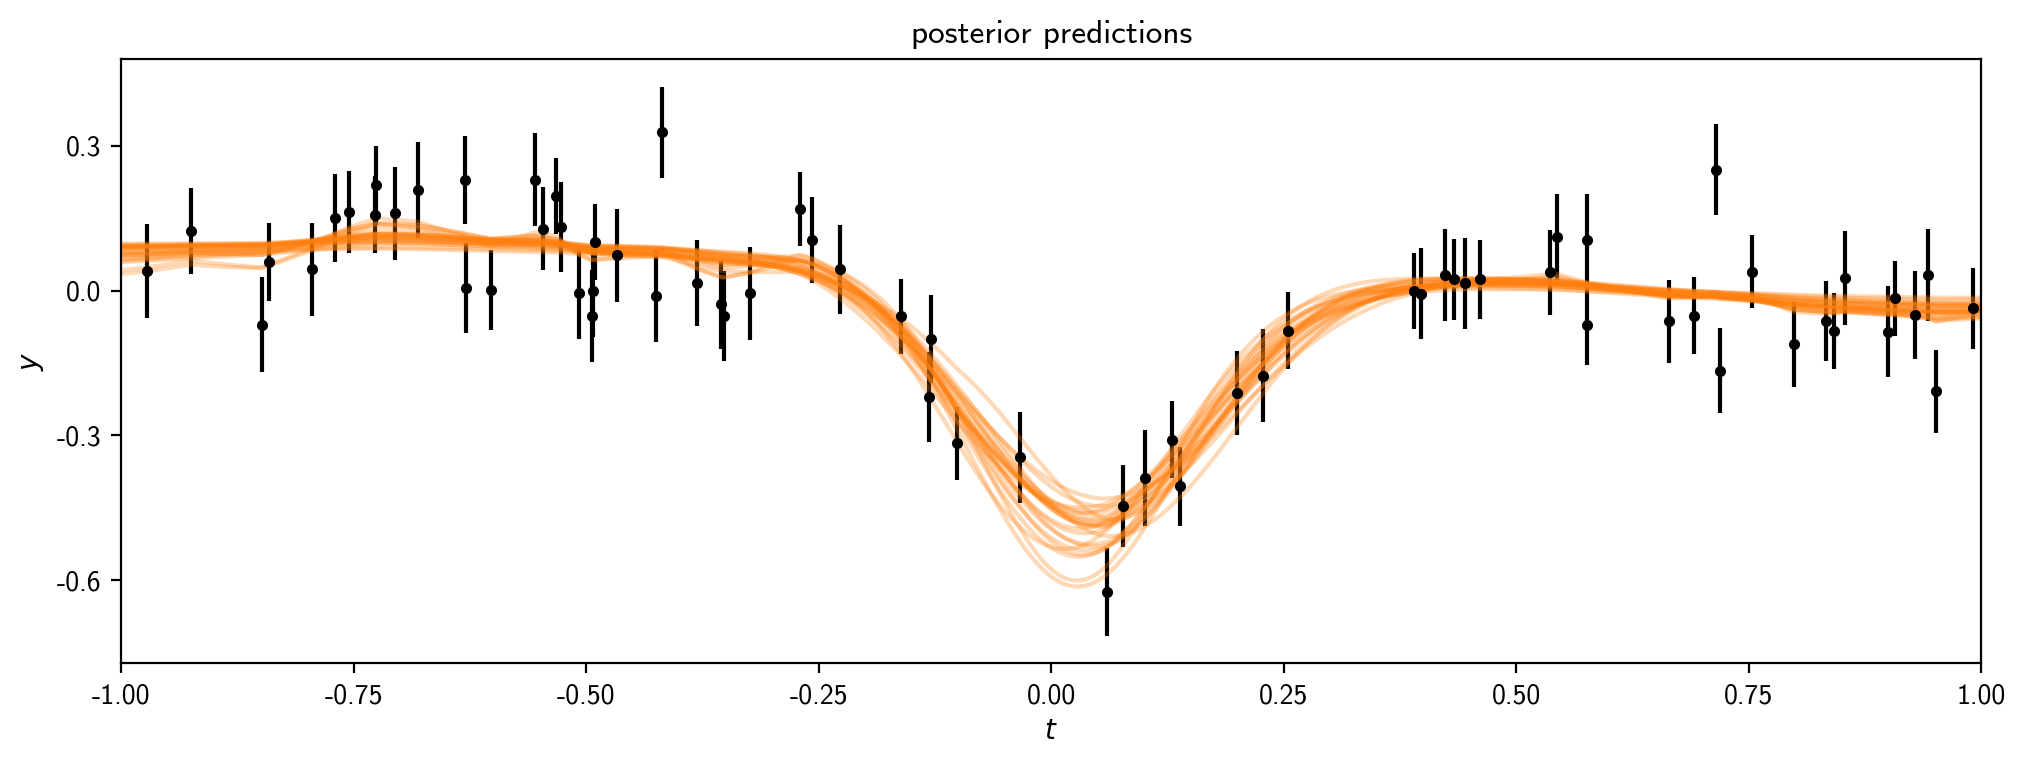

In [20]:
# Plot the data.
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)

# Plot 24 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=24)]:
    gp.set_parameter_vector(s)
    mu = gp.predict(y, t, return_cov=False)
    plt.plot(t, mu, color=color, alpha=0.3)

plt.ylabel(r"$y$")
plt.xlabel(r"$t$")
plt.xlim(-1, 1)
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))
plt.title("posterior predictions");

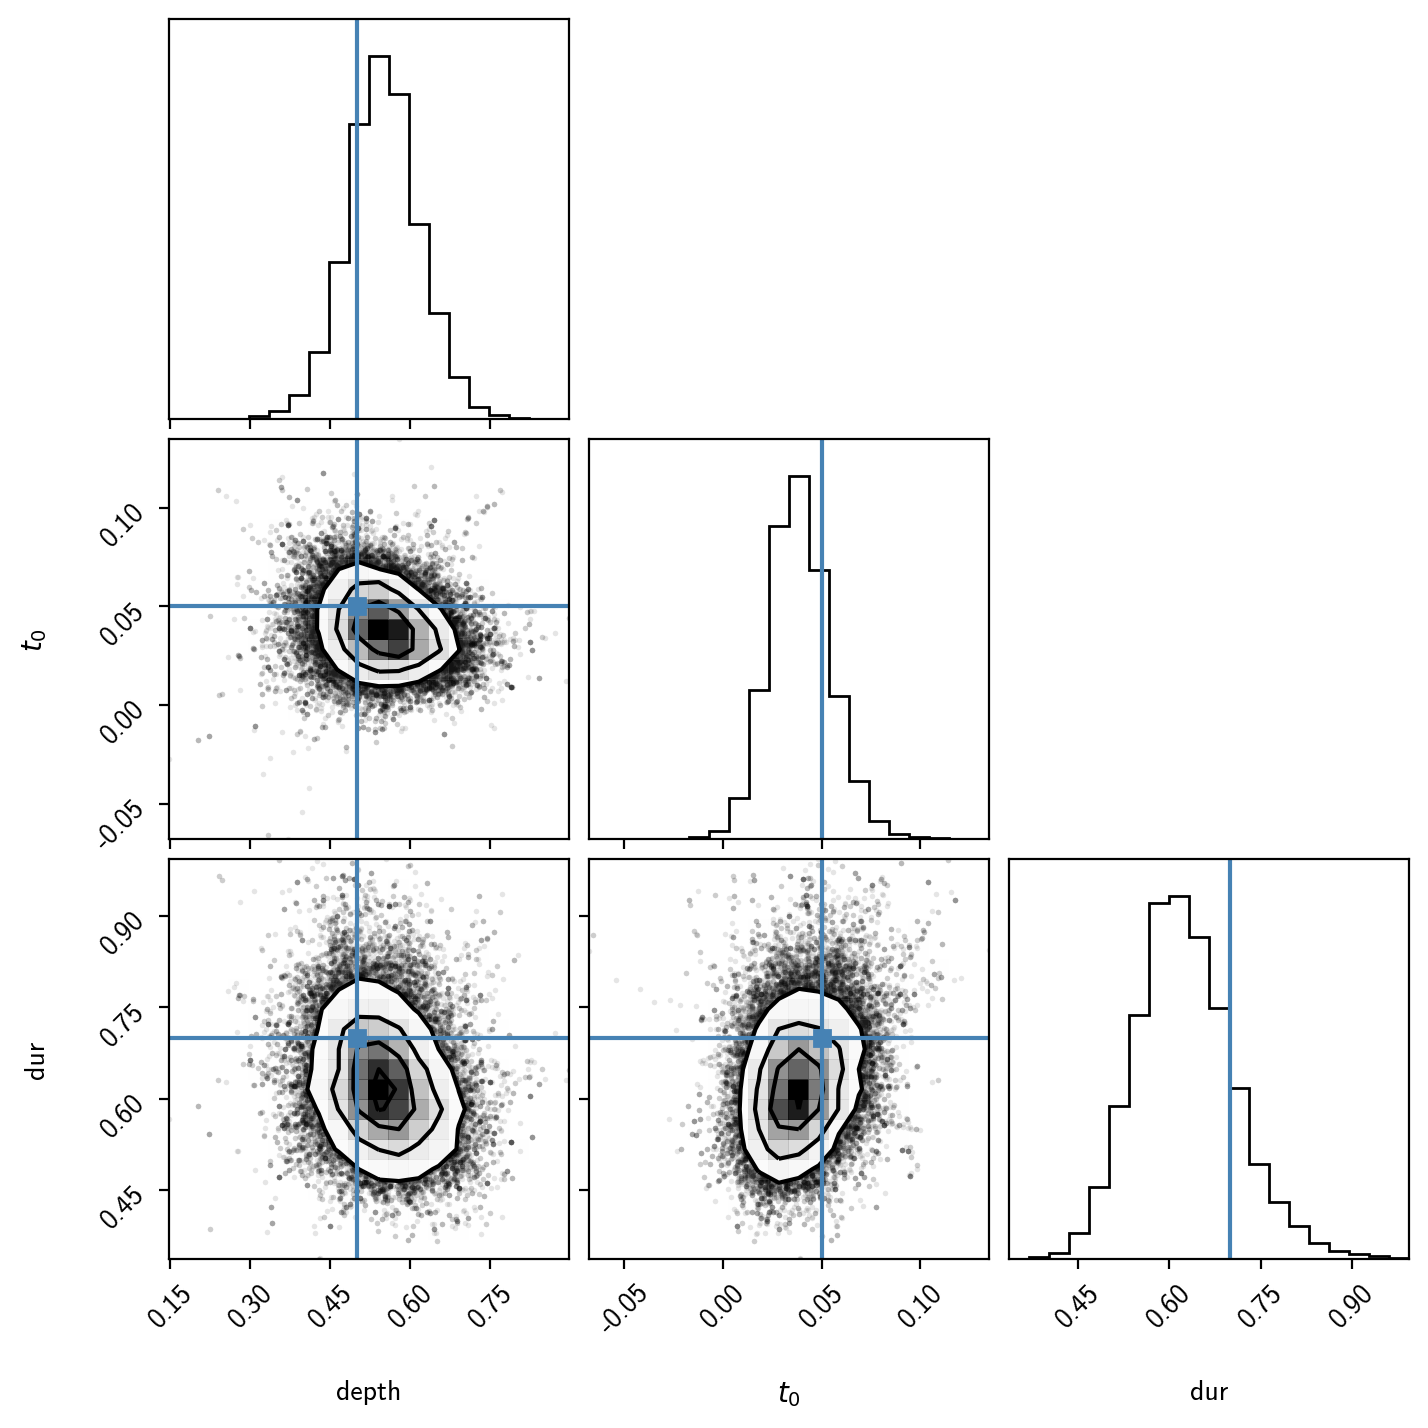

In [21]:
import corner
names = gp.get_parameter_names()
cols = mean_model.get_parameter_names()
inds = np.array([names.index("mean:"+k) for k in cols])
corner.corner(sampler.flatchain[:, inds], truths=true_params,
              labels=[r"depth", r"$t_0$", r"dur"]);

The transit time is inconsistent with 0 at about 3 sigma, so the claim that TTVs are present is *probably* true. But remember we're making strong assumptions about the nature of the correlated noise (we assumed a specific kernel), so in reality our uncertainty should be a bit higher.